# Análisis de la Canasta de Compras

## Introducción

##### En este proyecto, llevaremos a cabo un análisis de la canasta de compras para descubrir patrones en las compras de los clientes. Nuestro objetivo es identificar qué productos tienden a comprarse juntos, lo cual puede ofrecer insights valiosos para estrategias de marketing, diseño de promociones y gestión de inventario.

## Importación de Bibliotecas

##### Utilizaremos `pandas` para cargar, explorar y transformar nuestros datos en un formato adecuado para el análisis, tambien usaremos `mlxtend` para el análisis de cesta de mercado, aplicando algoritmos como Apriori para encontrar conjuntos de ítems frecuentes y generar reglas de asociación. Por ultimo, `matplotlib` y `seaborn` con las que crearemos gráficos y visualizaciones que nos ayuden a interpretar los datos y presentar nuestros hallazgos de manera clara y atractiva.

In [61]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
import seaborn as sns
import networkx as nx
from collections import Counter

## Carga y Exploración de Datos

##### En este caso, la exploración no resulta particularmente relevante, dado que prefiero procesar el dataset con antelación para asegurar la adecuación de los datos. Por lo tanto, ya estoy familiarizado con el contenido y confío en su consistencia.

In [19]:
origen = './datasets/ventas_golosinas_2023.csv'
data = pd.read_csv(origen)
data.head()

,Fecha,Comprobante,Cliente,Producto,Cantidad,Importe
0,2023-01-01,In-00113,Taylor Johnson,Frutas confitadas,10,22
1,2023-01-01,In-00200,Morgan Brown,Paletas,18,14
2,2023-01-01,In-00494,Casey Williams,Gomitas,15,18
3,2023-01-01,In-00664,Sam Smith,Galletas,11,22
4,2023-01-01,In-00897,Sam Davis,Turrones,9,22


##### Los registros se agrupan por 'Comprobante', organizando los productos en columnas. En estas, se asignan valores de 'verdadero' o 'falso' según si el producto se encuentra o no en el comprobante específico.

In [20]:
grouped = data.groupby('Comprobante')['Producto'].apply(list)

te = TransactionEncoder()
te_ary = te.fit(grouped).transform(grouped)
data_transformed = pd.DataFrame(te_ary, columns=te.columns_, index=grouped.index)
data_transformed.head()

,Bombones,Caramelos,Chicles,Chocolate,Frutas confitadas,Galletas,Gomitas,Marshmallows,Paletas,Turrones
Comprobante,,,,,,,,,,
In-00001,False,False,True,False,True,False,True,True,False,True
In-00002,False,False,True,True,False,True,False,True,True,False
In-00003,True,False,True,True,True,False,False,False,False,False
In-00004,True,False,False,False,False,True,False,False,False,False
In-00005,False,True,True,True,False,False,True,False,False,False


## Encontrar Conjuntos de Ítems Frecuentes

##### El primer paso implica determinar con qué frecuencia un producto aparece en cada transacción, utilizando para ello la función 'apriori'. Este proceso resultará en la obtención de un valor conocido como 'soporte'.

In [21]:
frequent_itemsets = apriori(data_transformed, min_support=0.01, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.244976,(Bombones)
1,0.222705,(Caramelos)
2,0.227594,(Chicles)
3,0.230853,(Chocolate)
4,0.248778,(Frutas confitadas)


## Reglas de Asociación

##### Después de identificar los conjuntos de ítems frecuentes, usaremos la función association_rules para generar reglas de asociación. Estas reglas nos ayudarán a entender qué productos tienden a ser comprados juntos.

In [22]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Caramelos),(Bombones),0.222705,0.244976,0.046714,0.209756,0.856233,-0.007844,0.955432,-0.177641
1,(Bombones),(Caramelos),0.244976,0.222705,0.046714,0.190687,0.856233,-0.007844,0.960438,-0.181928
2,(Chicles),(Bombones),0.227594,0.244976,0.051059,0.224344,0.915780,-0.004696,0.973401,-0.106396
3,(Bombones),(Chicles),0.244976,0.227594,0.051059,0.208426,0.915780,-0.004696,0.975785,-0.108579
4,(Chocolate),(Bombones),0.230853,0.244976,0.047257,0.204706,0.835618,-0.009296,0.949365,-0.203672


## Enfoques del análisis

### Relaciones entre productos

##### Filtraremos la tabla para enfocarnos en aquellos productos cuyo valor de 'lift' sea superior a 1.2. Esto nos permitirá concentrarnos en las tendencias más fuertes y significativas.

In [13]:
filtered_rules = rules[rules['lift'] > 1.2]
top_rules = filtered_rules.sort_values(by='confidence', ascending=False)
top_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
255,"(Chicles, Galletas)",(Gomitas),0.047257,0.258012,0.018468,0.390805,1.514676,0.006275,1.217980,0.356647
264,"(Chicles, Marshmallows)",(Gomitas),0.038566,0.258012,0.013036,0.338028,1.310126,0.003086,1.120876,0.246210
160,"(Galletas, Bombones)",(Paletas),0.053232,0.269419,0.017925,0.336735,1.249856,0.003583,1.101492,0.211148
333,"(Paletas, Galletas)",(Gomitas),0.060837,0.258012,0.019555,0.321429,1.245789,0.003858,1.093456,0.210076
304,"(Turrones, Chocolate)",(Gomitas),0.047800,0.258012,0.015209,0.318182,1.233206,0.002876,1.088249,0.198598


### Patrones Específicos de Compra entre Diferentes Categorías de Golosinas

##### Planteamos una manera visual de encontrar patrones específicos de compra entre diferentes categorías

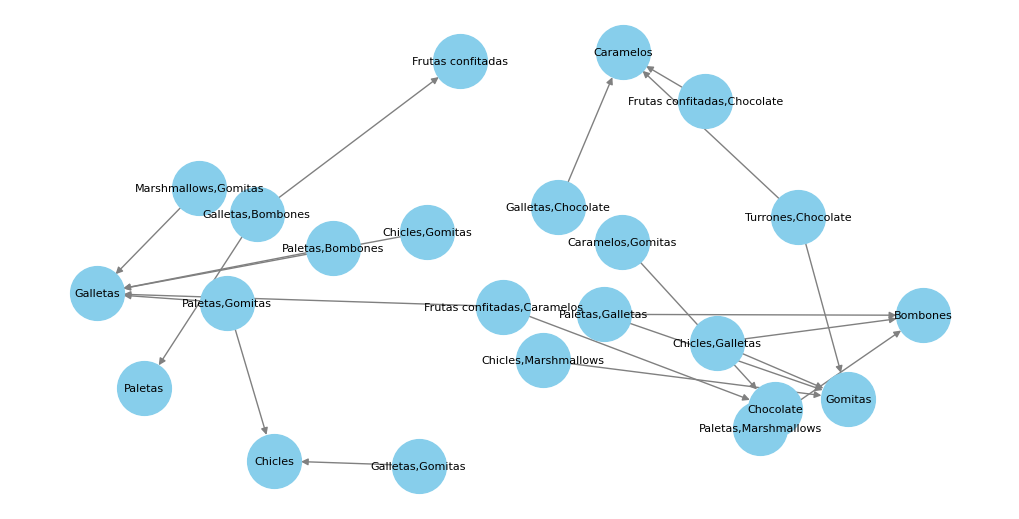

In [44]:
G = nx.DiGraph()

for index, row in top_rules.iterrows():
    # Para cada regla, añade una arista desde antecedents hasta consequents
    antecedents = ','.join(list(row['antecedents']))
    consequents = ','.join(list(row['consequents']))
    G.add_edge(antecedents, consequents, weight=row['confidence'])

plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G, k=0.5)  # k regula la distancia entre los nodos
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='grey', linewidths=1, font_size=8)

plt.show()

### Importancia de las Galletas en las Combinaciones

##### La frecuencia de las galletas en estas combinaciones sugiere su importancia central en las compras de los clientes. Esto podría indicar una oportunidad para promociones o para aumentar la visibilidad de este producto en la tienda.

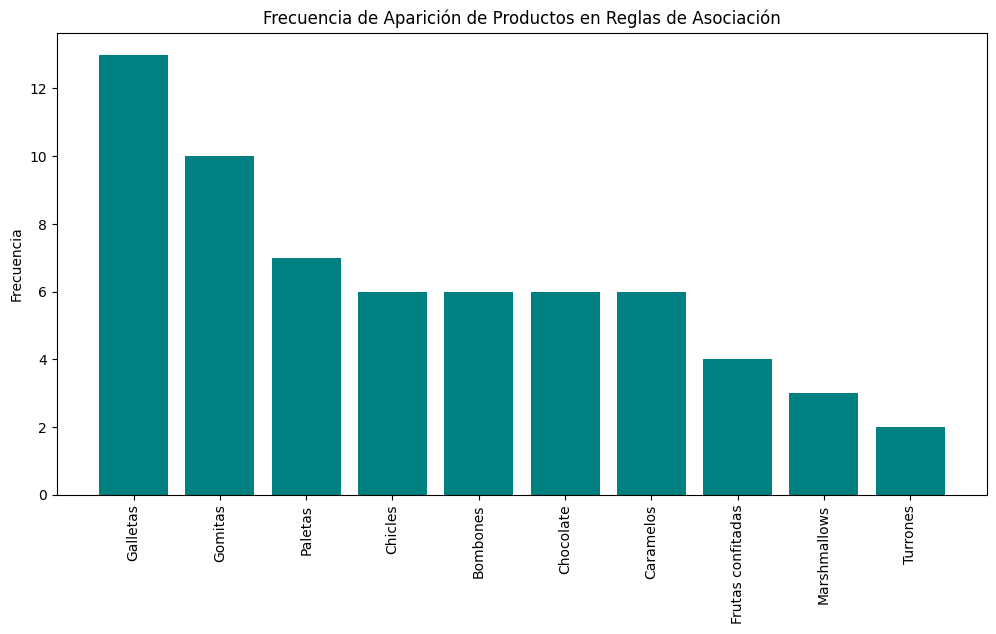

In [62]:
# Contar la frecuencia de todos los productos en antecedentes y consecuentes
frecuencia_total = Counter()
for productos in top_rules['antecedents']:
    frecuencia_total.update(productos)
for productos in top_rules['consequents']:
    frecuencia_total.update(productos)

# Extraer categorías y frecuencias
categorias = list(frecuencia_total.keys())
frecuencias = list(frecuencia_total.values())

# Ordenar los datos por frecuencia para una mejor visualización
categorias, frecuencias = zip(*sorted(zip(categorias, frecuencias), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))  # Ajustar el tamaño para mejor visualización
plt.bar(categorias, frecuencias, color='teal')
plt.title('Frecuencia de Aparición de Productos en Reglas de Asociación')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rotar las etiquetas para que sean legibles
plt.show()

### Diversidad en las Combinaciones de Productos

##### Esta diversidad en las combinaciones sugiere oportunidades para explorar promociones cruzadas más allá de los dulces tradicionales, potencialmente apuntando a una base de clientes más amplia.

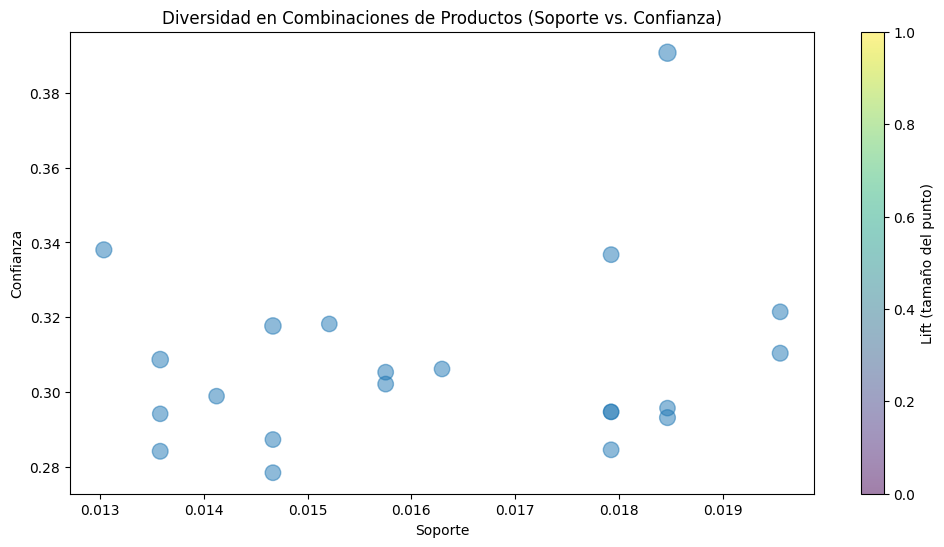

In [66]:
soporte = top_rules['support']
confianza = top_rules['confidence']
lift = top_rules['lift']

plt.figure(figsize=(12, 6))
plt.scatter(soporte, confianza, s=[l*100 for l in lift], alpha=0.5)  # El tamaño del punto es proporcional al lift
plt.title('Diversidad en Combinaciones de Productos (Soporte vs. Confianza)')
plt.xlabel('Soporte')
plt.ylabel('Confianza')
plt.colorbar(label='Lift (tamaño del punto)')  # Añadir una leyenda para el lift
plt.show()

# Conclusión

##### En este proyecto, hemos llevado a cabo un análisis detallado de la canasta de compras, utilizando un conjunto de datos de una tienda de golosinas. Nuestro enfoque se centró en descubrir patrones significativos en las compras de los clientes mediante el uso de reglas de asociación. Los resultados han revelado varios insights valiosos que pueden ser estratégicamente aplicados para mejorar las ventas y la experiencia del cliente.


## Principales Hallazgos:



##### Relaciones Significativas entre Productos: Identificamos combinaciones específicas de productos que se compran juntos con mayor frecuencia. Por ejemplo, las 'Galletas' mostraron una tendencia a ser compradas junto con 'Gomitas', destacando una fuerte correlación que puede ser aprovechada para promociones cruzadas.


##### Importancia de Productos Clave: Algunos productos, como las 'Galletas', aparecen con notable frecuencia tanto en los antecedentes como en los consecuentes de las reglas, indicando su papel central en las compras de los clientes.


##### Diversidad en Combinaciones de Productos: El análisis reveló una diversidad interesante en las combinaciones de productos, lo que sugiere que los clientes tienen preferencias variadas y que podrían responder positivamente a una amplia gama de opciones de emparejamiento de productos.


## Aplicaciones Prácticas:


### Estrategias de Marketing y Promociones:


##### Los insights obtenidos pueden informar estrategias de marketing más efectivas, como promociones específicas basadas en las combinaciones de productos más comunes.



### Optimización del Diseño de la Tienda:

##### Implementar experimentos en la tienda, como cambios en la disposición de los productos o pruebas A/B en promociones, para validar y refinar aún más los insights obtenidos.


### Personalización de Ofertas:


##### Conocer las preferencias de combinación de productos permite personalizar las ofertas a los clientes, potencialmente a través de programas de fidelización o campañas de marketing dirigidas.



## Recomendaciones:



##### Para maximizar el valor de este análisis, se sugiere la incorporación de datos adicionales, como información demográfica de clientes o datos de diferentes temporadas, para enriquecer el análisis. Es vital llevar a cabo experimentos prácticos en la tienda, como la reorganización de productos basada en las reglas de asociación identificadas o la realización de pruebas A/B en promociones, para validar y afinar los insights obtenidos. Además, dada la naturaleza dinámica de las preferencias de los clientes, se recomienda un monitoreo continuo y una revisión periódica de las tendencias de compra para asegurar que las estrategias de marketing y merchandising sigan siendo relevantes y efectivas.

